In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science'])
plt.rcParams.update({'font.size': 18, 'text.usetex': True})

In [2]:
# Load CVDV library
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from interface import CVDV

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled successfully!
Library loaded successfully!
Debug logs are written to: /home/luxi/cuda-cvdv/cuda.log
NOTE: Log file is cleared each time CVDV() is instantiated


In [3]:
# Simulation parameters
Q_N = 201          # Q function grid size
Q_MAX = 5.0        # Q function range
DV_LEVEL = 5
CV_LEVEL = 10      # CV register level (numQubits)

In [4]:
# Initialize three register system: [5, 5, CV_LEVEL]
# First two: small DV registers for joint measurement
# Last: CV register for Husimi-Q
sim = CVDV([DV_LEVEL, DV_LEVEL, CV_LEVEL])

# Initialize first two DV registers using formula:
N = 2**DV_LEVEL  # dimension = 2^5 = 32
dvInitCoeffs = np.zeros(N, dtype=complex)
for j in range(N):
    dvInitCoeffs[j] = np.exp(-(j - (N-1)/2)**2 * pi / (4 * N))
# Normalize
dvInitCoeffs /= np.linalg.norm(dvInitCoeffs)
sim.setCoeffs(0, dvInitCoeffs)
sim.setCoeffs(1, dvInitCoeffs)

# Initialize last register with Fock superposition
sim.setFocks(2, [1/2, 0, 1j/sqrt(2), 0, 1/2])
# sim.setFock(2, 0)

# Build tensor product and upload to device
sim.initStateVector()

# Print system info
sim.info()

Number of registers: 3
Total state size: 1048576 elements (0.016 GB in VRAM)
  Register 0: dim=32, qubits=5, dx=0.443113, x_bound=14.179631
  Register 1: dim=32, qubits=5, dx=0.443113, x_bound=14.179631
  Register 2: dim=1024, qubits=10, dx=0.078332, x_bound=80.212105


Computing joint measurement...
Size of joint Measurement: (32, 32)
Sum of joint measurement probabilities: 1.0000000000000004
Computing Husimi-Q...
Size of husimi_Q: (201, 201)
Integral of Q function over phase space: 0.999501781113386


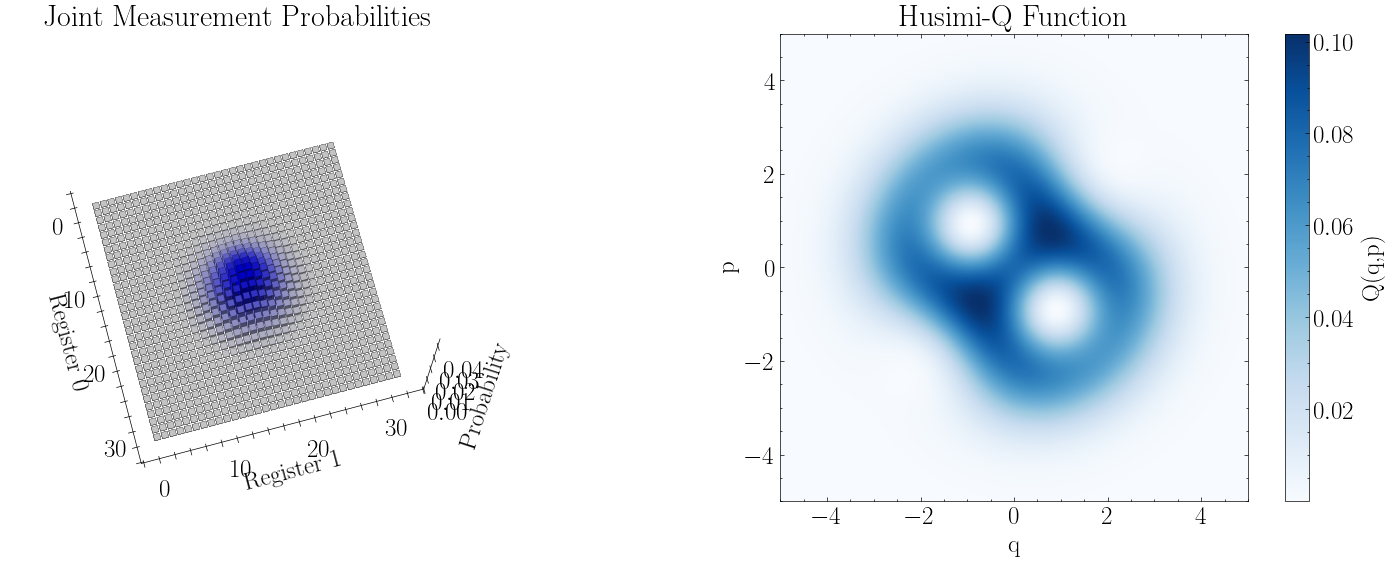

In [5]:
# Compute joint measurement of first two registers and Husimi-Q of last
def debugPlot():
    print("Computing joint measurement...")
    jointProbs = sim.jointMeasure(0, 1)
    print("Size of joint Measurement:", jointProbs.shape)
    print(f"Sum of joint measurement probabilities: {jointProbs.sum()}")

    print("Computing Husimi-Q...")
    qFuncVals = sim.getHusimiQFullMode(2, qN=Q_N, qMax=Q_MAX, pMax=Q_MAX)
    print("Size of husimi_Q:", qFuncVals.shape)
    print(f"Integral of Q function over phase space: {qFuncVals.sum() * ( (2*Q_MAX)/(Q_N-1) )**2 / 2}")

    # Create figure with two subplots
    fig = plt.figure(figsize=(16, 6))

    # --- 3D Bar Plot for Joint Probabilities ---
    ax1 = fig.add_subplot(121, projection='3d')

    # Create coordinate arrays for the bars
    N = 1<<DV_LEVEL
    x_pos = np.arange(N)
    y_pos = np.arange(N)
    x_pos, y_pos = np.meshgrid(x_pos, y_pos)
    x_pos = x_pos.flatten()
    y_pos = y_pos.flatten()
    z_pos = np.zeros_like(x_pos)

    # Bar dimensions
    dx = dy = 0.8
    dz = jointProbs.flatten()

    # Create white-to-blue colormap
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['white', 'blue']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('white_blue', colors, N=n_bins)
    
    # Normalize colors: 0 = white, max = full blue
    norm = plt.Normalize(vmin=0, vmax=jointProbs.flatten().max())
    colors = cmap(norm(jointProbs.flatten()))

    # Plot 3D bars with black edges
    ax1.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, 
              color=colors, shade=True, edgecolor='black', linewidth=0.1)
    
    # Set z-axis limits to show scaled height (0 to original max)
    ax1.set_zlim(0, jointProbs.flatten().max() * 3)
    
    # Clean up the plot
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('none')
    ax1.yaxis.pane.set_edgecolor('none')
    ax1.zaxis.pane.set_edgecolor('none')
    ax1.grid(False)
    
    # Set viewing angle
    ax1.view_init(elev=75, azim=-15)
    
    ax1.set_xlabel('Register 0')
    ax1.set_ylabel('Register 1')
    ax1.set_zlabel('Probability')
    ax1.set_title('Joint Measurement Probabilities')

    # --- Heatmap for Husimi-Q Function ---
    ax2 = fig.add_subplot(122)

    im = ax2.imshow(qFuncVals, extent=[-Q_MAX, Q_MAX, -Q_MAX, Q_MAX], 
                    origin='lower', cmap='Blues', aspect='equal')
    ax2.set_xlabel('q')
    ax2.set_ylabel('p')
    ax2.set_title('Husimi-Q Function')
    plt.colorbar(im, ax=ax2, label='Q(q,p)')

    plt.tight_layout()
    plt.show()

debugPlot()

Computing joint measurement...
Size of joint Measurement: (32, 32)
Sum of joint measurement probabilities: 1.0000000000000004
Computing Husimi-Q...
Size of husimi_Q: (201, 201)
Integral of Q function over phase space: 0.9999955137624126


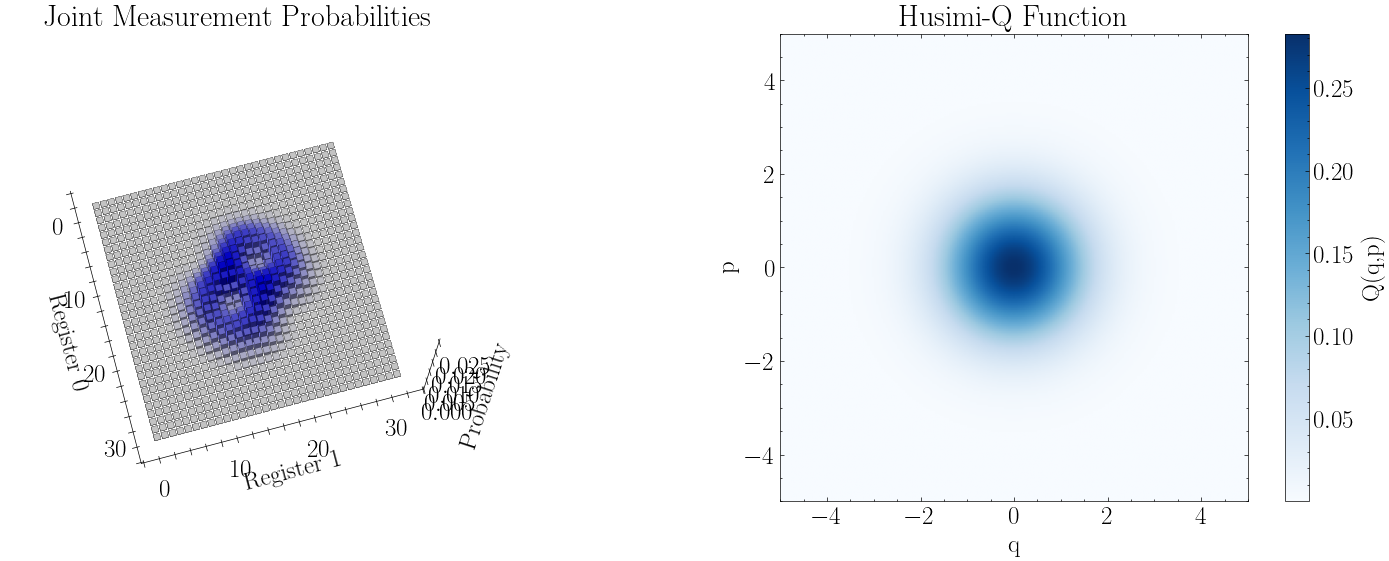

In [6]:
lam = 1
sim.q1q2(0, 2, lam/2)
sim.ftQ2P(2)
sim.q1q2(1, 2, lam)
sim.ftP2Q(2)
sim.q1q2(0, 2, lam/2)
sim.ftQ2P(0)
sim.ftQ2P(1)
sim.q1q2(1, 2, -0.5/lam)
sim.ftQ2P(2)
sim.q1q2(0, 2, 1/lam)
sim.ftP2Q(2)
sim.q1q2(1, 2, -0.5/lam)
debugPlot()